In [1]:
import pandas as pd
import networkx as nx
from matplotlib.pyplot import figure
import numpy as np

In [2]:
dis = pd.read_csv("disease_interactome.csv")
dis = dis[['OFFICIAL_SYMBOL_A','OFFICIAL_SYMBOL_B']]
dis

,OFFICIAL_SYMBOL_A,OFFICIAL_SYMBOL_B
0,A2M,APOE
1,A2M,LEP
2,A2M,NGF
3,ABAT,ACP6
4,ABAT,ADSL
...,...,...
6138,ZNF746,IDH2
6139,ZNF76,LETM1
6140,ZNF836,TBCD
6141,ZSCAN29,ABAT


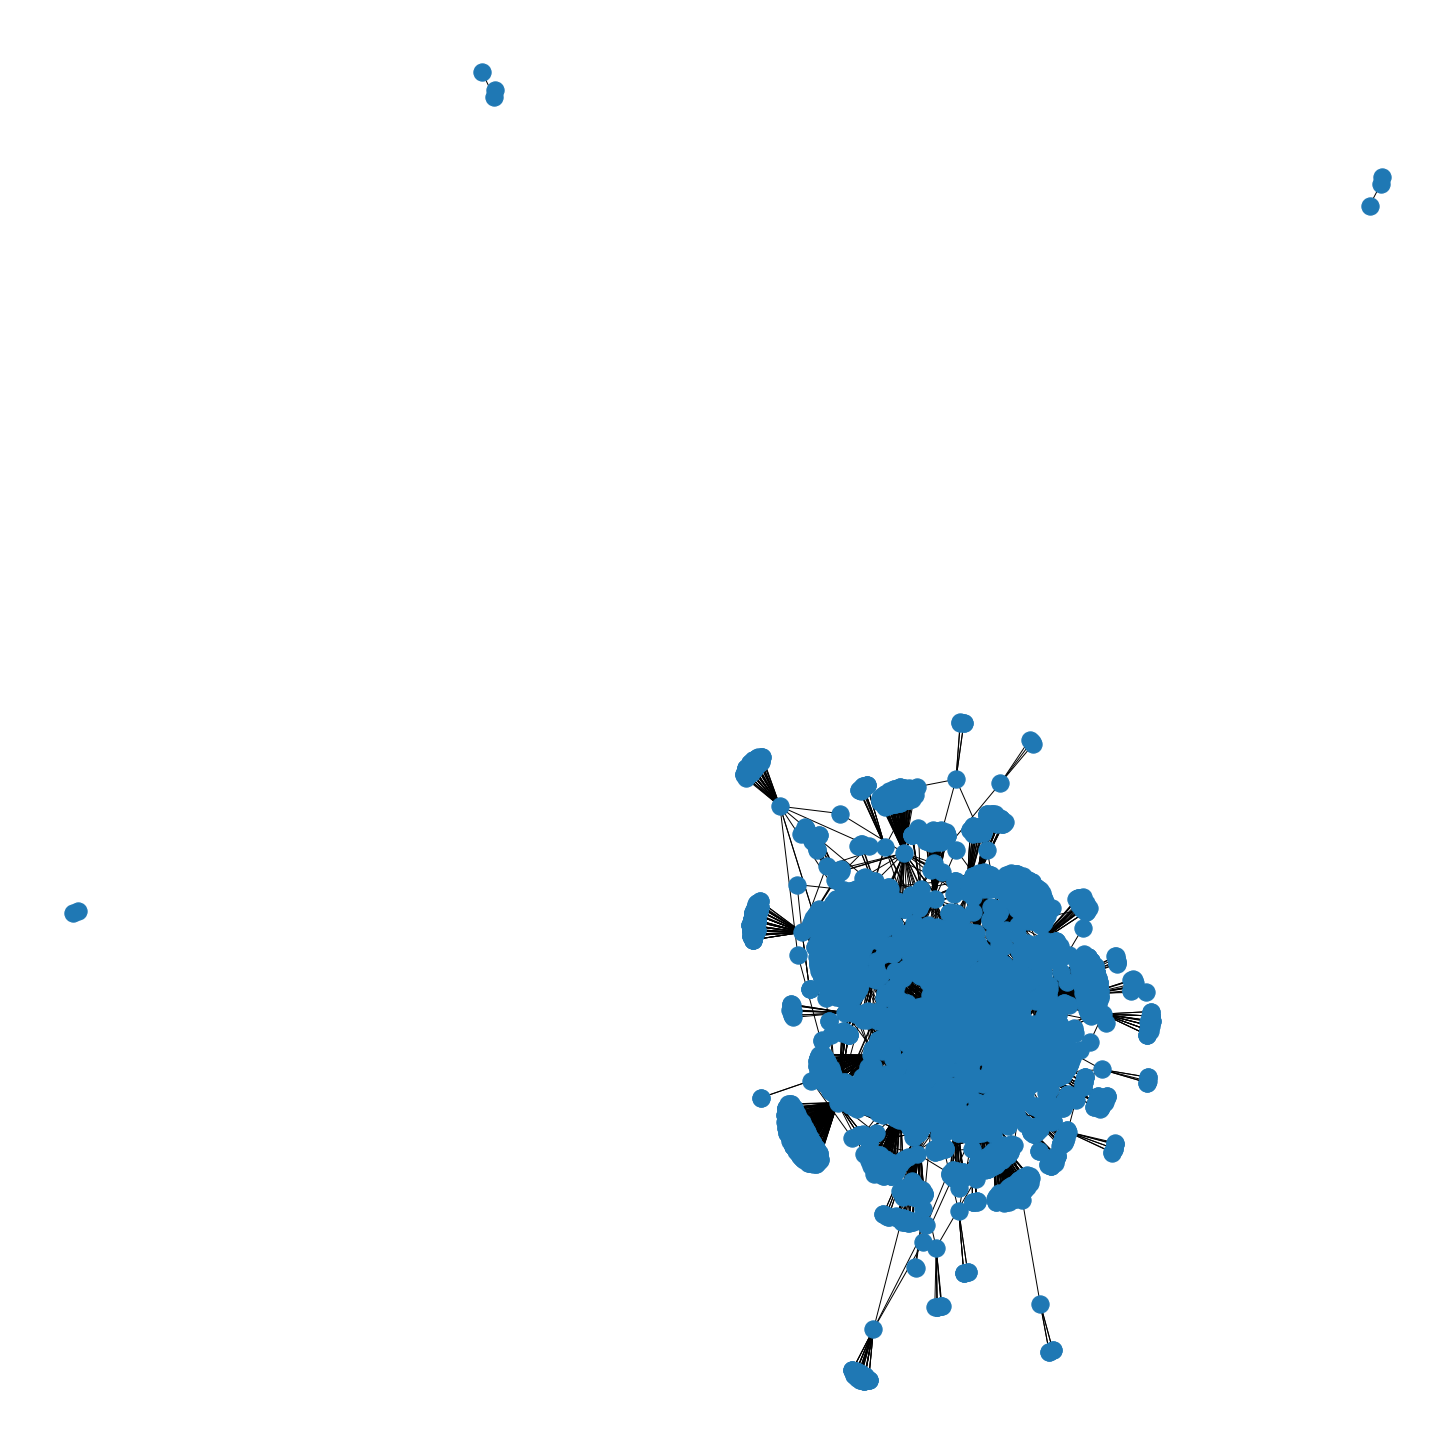

In [3]:
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(dis, 'OFFICIAL_SYMBOL_A',	'OFFICIAL_SYMBOL_B')

figure(figsize=(20, 20))
nx.draw(G, with_labels=False)

In [4]:
pip install markov_clustering[drawing]

In [5]:
pip install markov_clustering

In [6]:
import scipy 
import sklearn
import markov_clustering as mc

In [7]:
matrix = nx.adjacency_matrix(G)
# The rows and columns are ordered according to the nodes in nodelist. 
# If nodelist is None, then the ordering is produced by G.nodes().

# This means that nodes in the matrix are ordered like G.nodes. 
# So their cluster id should be their index inside G.nodes (???)

In [8]:
result = mc.run_mcl(matrix)           # run MCL with default parameters
clusters = mc.get_clusters(result)    # get clusters

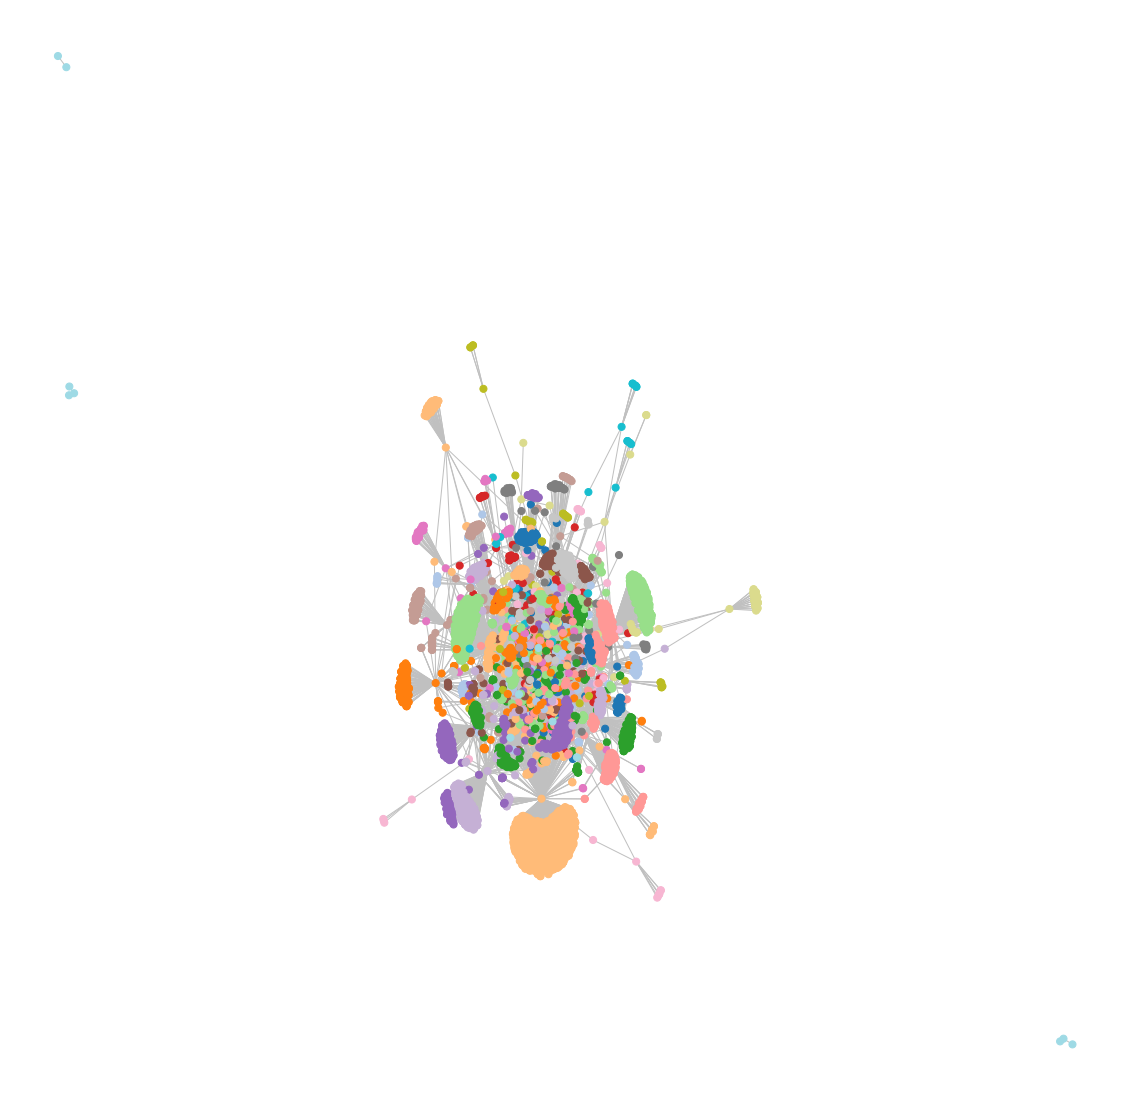

In [9]:
figure(figsize=(20, 20))
mc.draw_graph(matrix, clusters, node_size=50, with_labels=False, edge_color="silver")

In [ ]:
Q = mc.modularity(matrix=result, clusters=clusters)

In [ ]:
print(Q)

0.920894198234392


In [ ]:
# in theory we should try different inflation values and chose 
# the one that maximizes the modularity, but it's already pretty big

In [ ]:
with open("clusters.csv","w", newline="") as f:
  cw = csv.writer(f)
  cw.writerows(clusters)

In [10]:
from scipy.stats import hypergeom

In [ ]:
print(len(clusters))
print(len(max(clusters,key=len)))

97
776


In [62]:
#print(clusters)

In [11]:
# con almeno 10 nodi 
big_clusters = []
for c in clusters:
  if len(c)>= 10:
    big_clusters.append(c)

len(big_clusters)

61

In [63]:
#prendiamo i seed genes da R 
tmp = pd.read_csv('seed genes.csv', index_col=0)
tmp.head()
seeds = list(tmp["x"])
#print(seeds)
print(len(seeds))

101


In [64]:
#print(G.nodes)

In [13]:
# I need the IDs of the seeds, because the clusters are made of ids 
# let's check if the order thing is correct
nodi = list(G.nodes)
print(nodi.index("APOE")) 
# I know that he has a degree of 128 (Dario's code), so if the id is actually 1, the cluster 
# in which the id 1 appears should have around 128 elements
# Id 1 appears in cluster number 1, let's check. MMM boh
print(len(clusters[1]))

1
60


In [65]:
prova = [item for sublist in clusters for item in sublist]
#print(prova)
print(min(prova), max(prova))
print(matrix.shape)
prova.sort()
print( [*range(0,4160)] == prova)

# the ids are exactly the same as the matrix row! It should work then

0 4159
(4160, 4160)
True


In [66]:
# let's assume it's right and create the seed id list 
seeds_id = []
for s in seeds:
  if s in nodi: #apprently one seed gene is not in our disease interactome (no interactions?)
    seeds_id.append(nodi.index(s))

#print(seeds_id)
print(len(seeds_id))

100


In [ ]:
# M = population
# n = object with features
# N = draws
# x = succes in draws

In [46]:
# Looking for putative disease modules
pdm = []
population = len(G.nodes)
obj_with_features = len(seeds_id)

for bc in big_clusters:
  sample_size = len(bc)
  successi = len(list(set(bc) & set(seeds_id)))
  #print(successi)
  pval = hypergeom.sf(successi, population, obj_with_features, sample_size)
  #print(pval)
  if pval < 0.05:
    pdm.append(bc)
    print(successi)
    print(pval)


1
0.03755691076600075
1
0.04314197498784386
1
0.049014488987766065
1
0.03755691076600075
1
0.022703677750193774
1
0.03755691076600075
1
0.022703677750193774
1
0.03755691076600075
1
0.027319360957758995
1
0.03227668704580366
1
0.03227668704580366
1
0.03755691076600075


In [ ]:
len(pdm)

12

In [67]:
put_dis_moduls = pd.DataFrame(None, index= list(range(0,len(pdm))), columns=['ClusterID','N seeds','N genes','SeedIDs', 'GeneNames'])
put_dis_moduls['p-value'] = [0.0]*12
#put_dis_moduls

In [68]:
for i in put_dis_moduls.index: 
  p = pdm[i]
  put_dis_moduls['ClusterID'][i]= clusters.index(p)
  successi = len(list(set(p) & set(seeds_id)))
  put_dis_moduls['N seeds'][i] = successi
  put_dis_moduls['N genes'][i] = len(p)
  seedsT =[]
  for s in (set(p) & set(seeds_id)):
    seedsT.append(nodi[s])
  put_dis_moduls['SeedIDs'][i] = seedsT
  #put_dis_moduls['GenesIDs'][i] = set(p)
  nomi_geni = []
  for id in p:
    nomi_geni.append(nodi[id])
  
  put_dis_moduls['GeneNames'][i] = set(nomi_geni)

  sample_size = len(p)
  pval = hypergeom.sf(successi, population, obj_with_features, len(p))
  put_dis_moduls['p-value'][i] = pval 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6

In [69]:
put_dis_moduls

,ClusterID,N seeds,N genes,SeedIDs,GeneNames,p-value
0,6,1,13,[DRD1],"{COPG1, COPG2, HRH3, GHSR, RANBP9, DRD1, DNAJC...",0.037557
1,15,1,14,[KCNJ11],"{LDHA, KCNJ11, CDH5, YWHAB, GDPD5, EXOSC8, SLC...",0.043142
2,25,1,15,[SIGMAR1],"{TCTN3, RNF4, LMBR1L, HSCB, ANK2, CFTR, ITFG1,...",0.049014
3,29,1,13,[AGT],"{ACE, REN, LNPEP, HSPA5, EWSR1, GSDMB, NDUFA3,...",0.037557
4,52,1,10,[GAMT],"{RAB24, BCAR1, GAMT, BICD2, POT1, FSD1, FARS2,...",0.022704
5,64,1,13,[BDNF],"{LOC102724334, NTRK2, AGO3, BDNF, F11R, HIST1H...",0.037557
6,66,1,10,[SLC8A3],"{CSGALNACT2, SPPL2B, SLC8A2, TMEM43, GPD2, REE...",0.022704
7,68,1,13,[PIGM],"{GABRE, POMK, CHEK1, LTB4R2, HTR3C, PTH1R, CND...",0.037557
8,74,1,11,[SYN2],"{YWHAE, SYN3, SYN2, PSMC3, ARMC1, HAX1, POLL, ...",0.027319
9,77,1,12,[NOS1],"{SOX2, NOS1, RASD1, NOS1AP, DLG2, DMD, SYN1, Z...",0.032277


In [47]:
put_dis_moduls.to_csv("putative_disease_modules.csv")